# 2. Modelling


## To Do


And:
- Look at featire importance like this: https://www.perplexity.ai/search/in-preparing-data-for-a-classi-KAMPukk9QVGi1qoidTcUiQ
- MLP - Use Keras to create an MLP, see week 5 Wine notebook
- Add a loop like week 9 to produce a summary comparison? .. or just do manually in poster
- One best model found then retrain again and get different metrics??
- Repeat with PCA components to improve feature selection
- ?? use print("The probabilities across the possible classes for that output are", model.predict_proba(X_test[0:1]))




## Imports & Utilities

In [1]:
# General stuff
import os
import time

# Import maths related packages
import pandas as pd
import numpy as np
import math

# Import plotting packages
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Reset to Default
# plt.style.use('default')


In [2]:
# ML Models & Evaluation

from sklearn import model_selection

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


In [3]:
# Function to Display The Model Fit Results

def print_search_results(search, duration):
    print('------- Search Results --------')
    all_search_results = pd.DataFrame(search.cv_results_)
    print(f"Score: {search.best_score_:.4f}. Mean: {np.mean(all_search_results['mean_test_score']):.4f} and STD {np.std(all_search_results['mean_test_score']):.4f}")
    print(f'Search Took: {duration:.2f} seconds')
    print(f"Best Parameters: {search.best_params_}")
    top_n = 10
    print(f"Top {top_n} out of {len(all_search_results)} combinations:")
    display(all_search_results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']].sort_values(by='rank_test_score').head(top_n))

In [4]:
# Function to Present the Evaluation Metrics for a Classification Model

def classification_metrics(for_Model, X_test, y_test, y_pred):
    plt.style.use('default')

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print various metrics
    print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Precision: {metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'Recall: {metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'F1 Score {metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label="yes"):.4f}')
    print(f'Specificity: {tn / (tn + fp):.4f}')
    print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')


    # Plot Confusion Matrix
    class_labels = for_Model.classes_
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax)
    plt.show

    y_probabilities = for_Model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probabilities)
    print(f'ROC-AUC Score {roc_auc_score:.4f}')
    gini_score = 2 * roc_auc_score - 1
    print(f'Gini Index: {gini_score:.4f}')

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve')
    roc_display = RocCurveDisplay.from_estimator(for_Model, X_test, y_test, ax=ax, pos_label="yes")
    plt.show()

    plt.style.use('ggplot')

## Load the Prepared Data

In [5]:
# Load saved dataset
import pickle

with open('xy_data.pickle', 'rb') as file:
    X_train, X_test, y_train, y_test, feature_names = pickle.load(file)

In [6]:
# Create custom scorers to cater for 'yes/no' vs '0/1' target variable 
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
custom_precision_score = make_scorer(precision_score, pos_label='yes')
custom_recall_score = make_scorer(recall_score, pos_label='yes')
custom_f1_score = make_scorer(f1_score, pos_label='yes')

# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']


## Logistic Regression

In [7]:
# Logistic Regression

# Establish a pipeline for a randomised search & get the best fitted model
logreg_pipeline = make_pipeline(
    LogisticRegression(random_state=42)
)
grid_params = {
    'logisticregression__solver': ['saga', 'lbfgs', 'liblinear'],           # Default is lbfgs. Saga with L1 or l2. Large dataset. liblinear small datasets, binary classifications
    'logisticregression__penalty': ['l2'],               # Default L2. L1 or L2 regularisation. Only L2 with Lbfgs
    'logisticregression__C': [0.1, 1, 5, 10],                # Default is 1. Strength of regularisation, smaller is stronger
    # 'logisticregression__class_weight': [None, 'balanced'],    # Tries to adjust classes that are imbalanced .... search gives non, but balanced seems better
    'logisticregression__class_weight': ['balanced'],           # Default None. Balanced seems to prevent near zero True predictions
    'logisticregression__max_iter': [5000]                      # Default 100. ??? iterations seems to be sufficient
}
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Run the search
start_time = time.perf_counter()
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring=scoring, cv=5, refit='accuracy')
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring='accuracy', cv=5)
# rand_search = GridSearchCV(logreg_pipeline, grid_params, scoring='roc_auc', cv=5)
# logreg_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring='roc_auc', cv=5)
logreg_search = GridSearchCV(logreg_pipeline, grid_params, scoring=custom_precision_score, cv=5)

logreg_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time


------- Search Results --------
Score: 0.3520. Mean: 0.3496 and STD 0.0016
Search Took: 14.19 seconds
Best Parameters: {'logisticregression__C': 5, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 5000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Top 10 out of 12 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
6,1,0.352028,0.424356,0.022942,"{'logisticregression__C': 5, 'logisticregressi..."
9,2,0.352028,0.425052,0.022890,"{'logisticregression__C': 10, 'logisticregress..."
3,3,0.351957,0.464733,0.023381,"{'logisticregression__C': 1, 'logisticregressi..."
0,4,0.351317,0.434743,0.036757,"{'logisticregression__C': 0.1, 'logisticregres..."
7,5,0.348774,0.088038,0.022983,"{'logisticregression__C': 5, 'logisticregressi..."
10,6,0.348753,0.087881,0.022991,"{'logisticregression__C': 10, 'logisticregress..."
11,7,0.348658,0.081922,0.023027,"{'logisticregression__C': 10, 'logisticregress..."
5,8,0.348654,0.082038,0.022847,"{'logisticregression__C': 1, 'logisticregressi..."
8,9,0.348635,0.081958,0.023051,"{'logisticregression__C': 5, 'logisticregressi..."
4,10,0.348481,0.086931,0.023007,"{'logisticregression__C': 1, 'logisticregressi..."


Accuracy: 0.7015
Precision: 0.3526
Recall: 0.6607
F1 Score 0.4598
Specificity: 0.7113
Hamming Loss 0.2985
ROC-AUC Score 0.7497
Gini Index: 0.4995


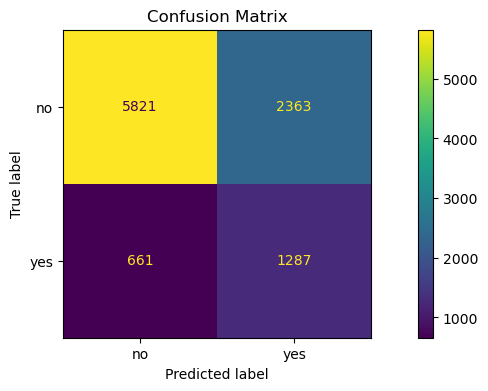

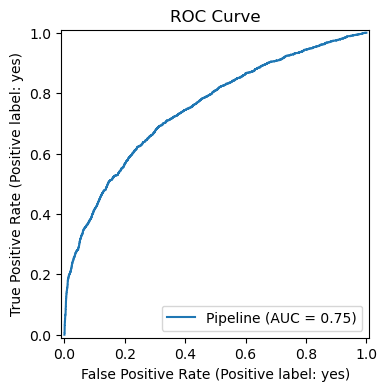

In [8]:
# Show the results
print_search_results(logreg_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_logreg = logreg_search.best_estimator_
y_pred = model_logreg.predict(X_test)
classification_metrics(model_logreg, X_test, y_test, y_pred)

## Decision Tree - Random Forest

In [9]:
# Decision Tree

# Establish a pipeline for a grid search & get the best fitted model
randforest_pipeline = make_pipeline(
    RandomForestClassifier(random_state=42)
)
grid_params = {
    # 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']      # Default gini. Tree split evaluation function
    'randomforestclassifier__criterion': ['entropy'],                           # Default gini. Tree split evaluation function, 
    # 'randomforestclassifier__n_estimators': [100, 200]                        # Default 100. Number of trees
    'randomforestclassifier__max_depth': [50],                                  # Default none
    # 'randomforestclassifier__max_leaf_nodes': [5, 50],
    # 'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__class_weight': ['balanced']            # Gives more importance to minority classes ... ?? Improves recall at the expense of precision
}                       

# Run the search
start_time = time.perf_counter()
randforest_search = GridSearchCV(randforest_pipeline, grid_params, scoring=custom_precision_score, cv=5)
# randforest_search = RandomizedSearchCV(randforest_pipeline, grid_params, cv=5)
randforest_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time

------- Search Results --------
Score: 0.8051. Mean: 0.8051 and STD 0.0000
Search Took: 64.38 seconds
Best Parameters: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 50}
Top 10 out of 1 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1,0.805076,9.960819,0.1378,{'randomforestclassifier__class_weight': 'bala...


Accuracy: 0.9337
Precision: 0.8408
Recall: 0.8080
F1 Score 0.8241
Specificity: 0.9636
Hamming Loss 0.0663
ROC-AUC Score 0.9242
Gini Index: 0.8485


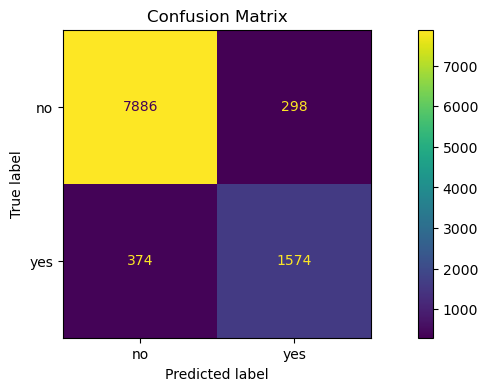

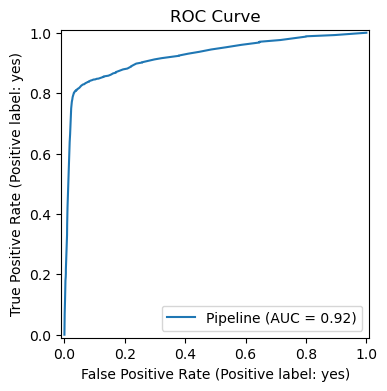

In [10]:
# Show the results
print_search_results(randforest_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_randforest = randforest_search.best_estimator_
y_pred = model_randforest.predict(X_test)
classification_metrics(model_randforest, X_test, y_test, y_pred)

### Feature Importance

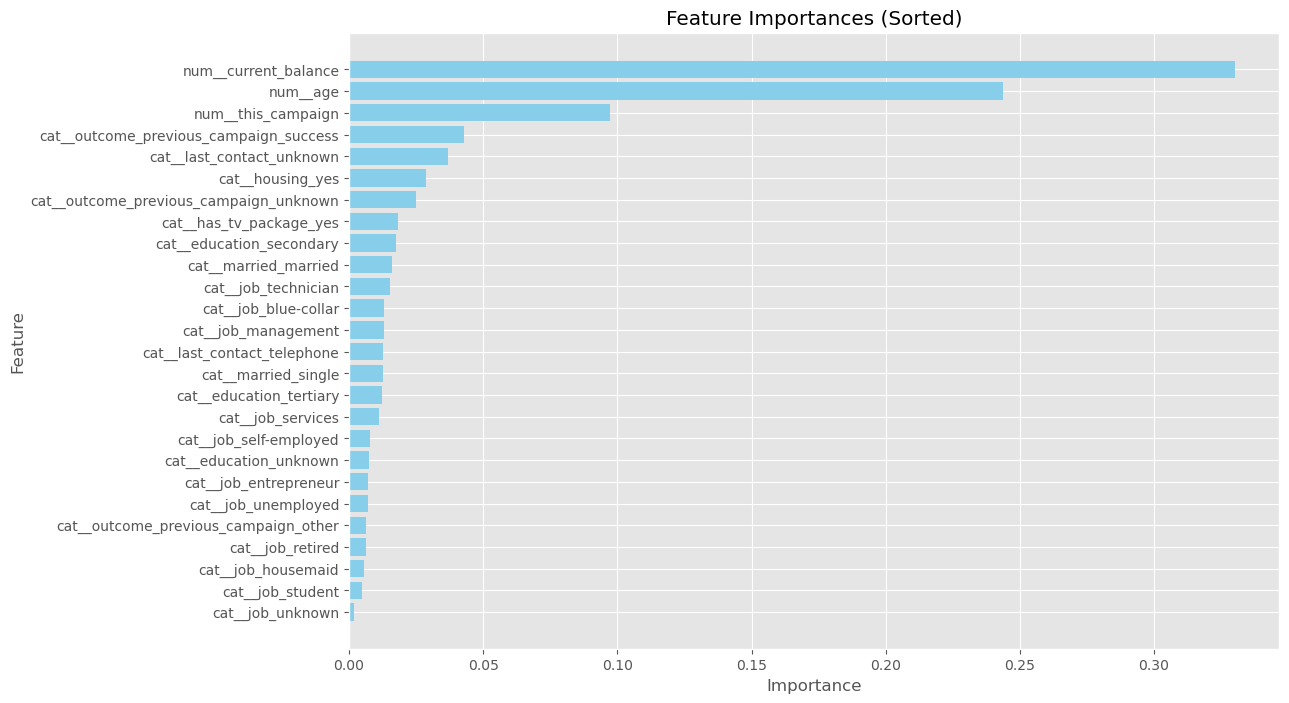

In [15]:
# Get feature importances
importances = model_randforest.named_steps['randomforestclassifier'].feature_importances_

# Map feature importances to feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# print(importance_df)

# Plot the feature importances with names horizontally
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

## Neural Network - MLPClassifier

In [12]:
# Neural Network


# param_grid = {
#     'hidden_layer_sizes': [(50,), (30, 15), (100,)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam', 'lbfgs'], # Default adam
#     'alpha': [0.0001, 0.001], # default is L2, 0.0001
#     'learning_rate_init': [0.001, 0.01] 
# }
# https://www.perplexity.ai/search/for-an-mlpclassifier-what-are-nqkwHGTVRRq6kH6L03t6gw
# https://www.perplexity.ai/search/what-are-the-scimitar-default-E_9Y.WQmRqyXuSKdXF.3Ww


# Establish a pipeline for a grid or random search to get the best fitted model
mlpclass_pipeline = make_pipeline(
    MLPClassifier(random_state=42)
)
grid_params = {
    'mlpclassifier__hidden_layer_sizes': [(25, 5)],             # Default, single layer of 100
    'mlpclassifier__activation': ['tanh'],                      # Default: relu
    'mlpclassifier__alpha': [0.1],                              # default is L2, 0.0001,
    'mlpclassifier__max_iter': [500]                            # Default 200
}

# Run the search
start_time = time.perf_counter()
# rand_search = RandomizedSearchCV(logreg_pipeline, grid_params, scoring='accuracy', cv=5)
# mlpclass_search = RandomizedSearchCV(mlpclass_pipeline, grid_params, scoring=custom_f1_score, cv=5)
mlpclass_search = GridSearchCV(mlpclass_pipeline, grid_params, scoring=custom_f1_score, cv=5)


mlpclass_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time


------- Search Results --------
Score: 0.3563. Mean: 0.3563 and STD 0.0000
Search Took: 17.05 seconds
Best Parameters: {'mlpclassifier__activation': 'tanh', 'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (25, 5), 'mlpclassifier__max_iter': 500}
Top 10 out of 1 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1,0.356322,2.77576,0.02248,"{'mlpclassifier__activation': 'tanh', 'mlpclas..."


Accuracy: 0.8324
Precision: 0.6860
Recall: 0.2367
F1 Score 0.3519
Specificity: 0.9742
Hamming Loss 0.1676
ROC-AUC Score 0.7634
Gini Index: 0.5269


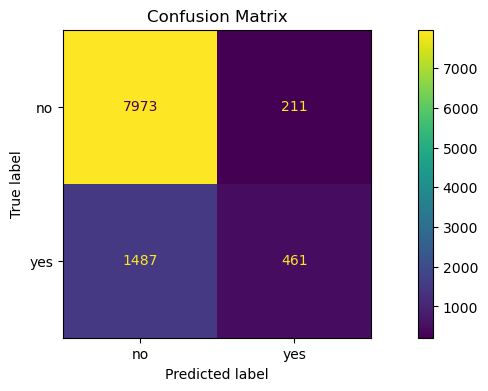

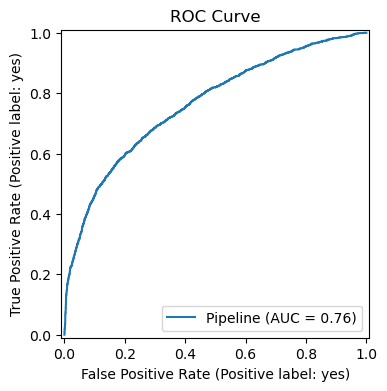

In [13]:
# Show the results
print_search_results(mlpclass_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_mlpclass = mlpclass_search.best_estimator_
y_pred = model_mlpclass.predict(X_test)
classification_metrics(model_mlpclass, X_test, y_test, y_pred)

# ?? use
# print("The probabilities across the possible classes for that output are", model.predict_proba(X_test[0:1]))

# from sklearn.model_selection import cross_val_score
# cv_accuracy = np.mean(cross_val_score(model_clf, X_train, y_train, cv=5))
# print(cv_accuracy)